# mAD Gene Expression Analysis

In [1]:
# Loading the Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects

from starmap.obj import STARMapDataset, load_data
import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#from statannot import add_stat_annotation ### DEBUG: statannot is deprecated, use statannotations
from statannotations.Annotator import Annotator


# test
from starmap.utilities import *
from starmap.sequencing import *
from anndata import AnnData

# test()

In [2]:
# Colormap related
import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

## Input

In [19]:
# Change to Data folder
os.chdir('/mnt/d/Stellaromics/Data/AD/SCP1375/2022-01-11-mAD-64-genes-processed-images/')

In [20]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(out_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

In [21]:
### DEBUG: modify sample names for downstream code
sample_names_dict = {'8months_control-ADmouse_9781/trimmed_images':'AD_mouse9781', '8months_disease-ADmouse_9721/trimmed_images':'AD_mouse9721', '13months_control-ADmouse_9930/trimmed_images':'AD_mouse9930', '13months_disease-ADmouse_9919/trimmed_images':'AD_mouse9919'}
adata.obs['sample'] = adata.obs['sample'].map(sample_names_dict)

In [22]:
# # add batch information 
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'batch'] = 'batch_1'
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'batch'] = 'batch_1'
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'batch'] = 'batch_2'
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9981', 'batch'] = 'batch_2'

# add time information 
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'time'] = '8_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'time'] = '8_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'time'] = '13_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9930', 'time'] = '13_months'

# add group information 
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'group'] = 'disease'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'group'] = 'control'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'group'] = 'disease'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9930', 'group'] = 'control'

# change dtype
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(['AD_mouse9781', 'AD_mouse9721', 'AD_mouse9930', 'AD_mouse9919'])

# adata.obs['batch'] = adata.obs['batch'].astype('category')
# adata.obs['batch'] = adata.obs['batch'].cat.reorder_categories(['batch_1', 'batch_2'])

adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['time'] = adata.obs['time'].cat.reorder_categories(['8_months', '13_months'])

adata.obs['group'] = adata.obs['group'].astype('category')

In [25]:
adata

AnnData object with n_obs × n_vars = 40952 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'time', 'group'

In [26]:
adata.obs['sample'].value_counts()

AD_mouse9781    11328
AD_mouse9919    10404
AD_mouse9930     9829
AD_mouse9721     9391
Name: sample, dtype: int64

## Preprocessing

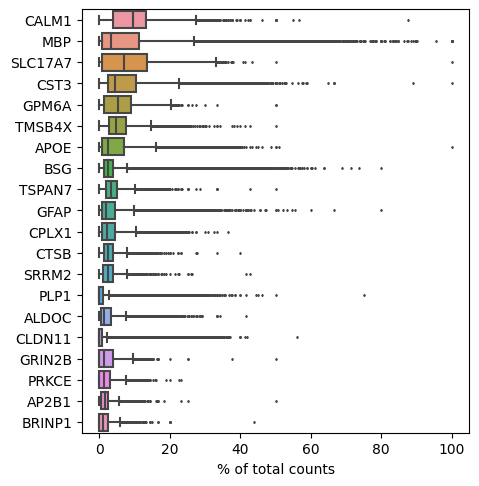

In [27]:
# Plot top 20 most expressed genes 
sc.pl.highest_expr_genes(adata, n_top=20)

In [28]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
adata.var['max_counts'] = adata.X.max(axis=0)

<AxesSubplot: xlabel='max_counts'>

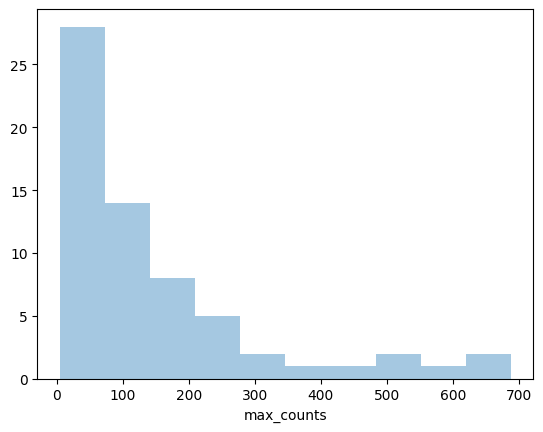

In [29]:
sns.distplot(adata.var['max_counts'], kde=False, )

In [ ]:
# Per-cell Stats Plot

# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'log1p_total_counts'],
#              jitter=0.4, multi_panel=True)

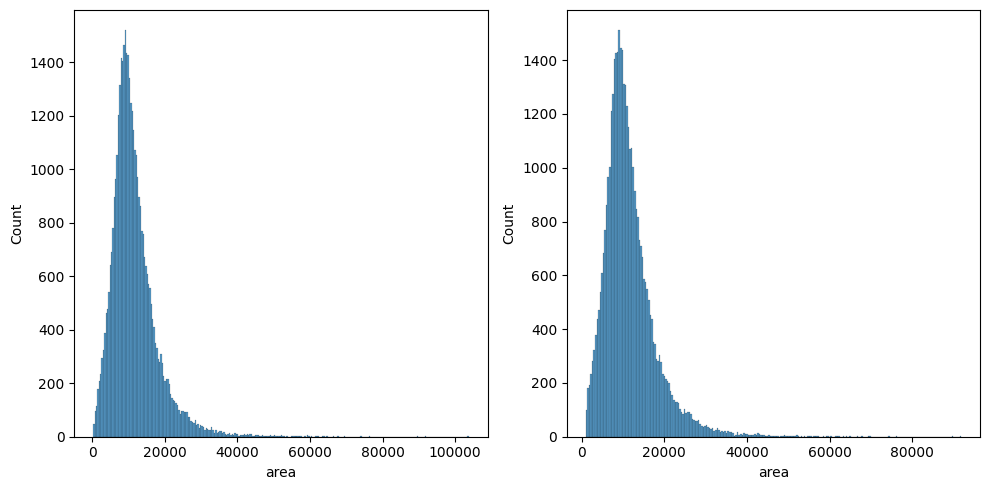

Number of cell left: 40824


In [34]:
# Filter cell by area 
adata = su.filter_cells_by_area(adata, min_area=1000, max_area=100000, save=True)

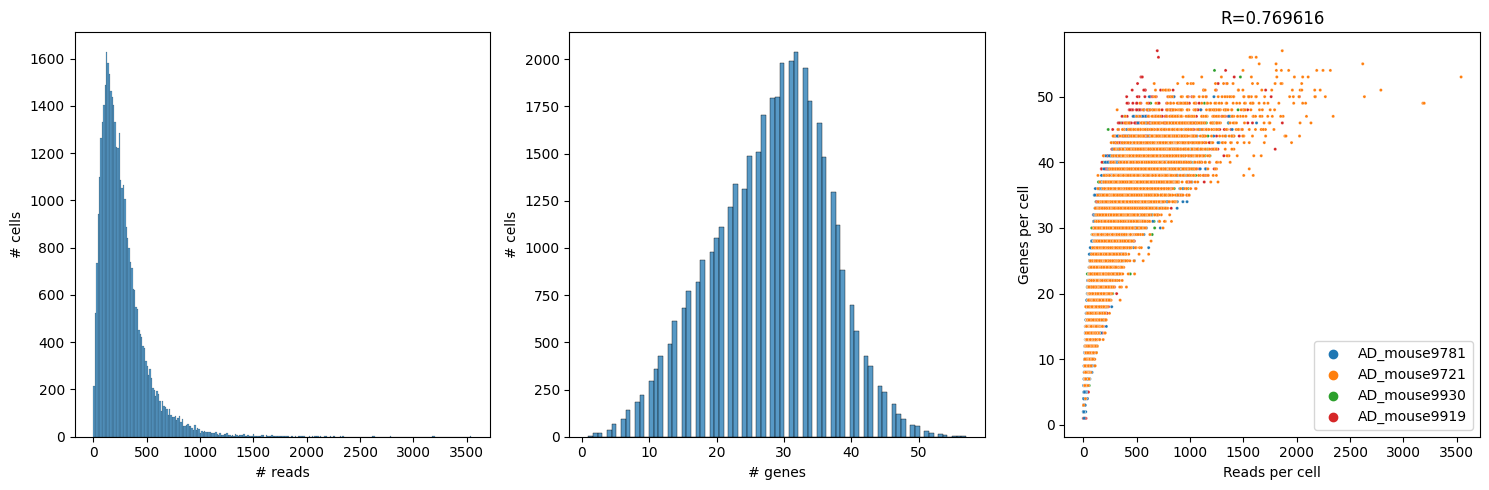

In [35]:
# Per-cell Stats Plot

su.plot_stats_per_cell(adata, save=True)

In [36]:
# Get quantiles of reads

su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     73.0
0.25    129.0
0.50    222.0
0.75    355.0
0.90    532.0
Name: total_counts, dtype: float64


In [37]:
# Get a copy of meta data
meta = adata.obs.copy()

# Filtration 
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

# Filter gene by max counts 
adata = adata[:, adata.var['max_counts'] > 2]

sc.pp.filter_cells(adata, min_counts=73)
sc.pp.filter_cells(adata, max_counts=1500)

adata.layers['raw'] = adata.X
adata.X.shape

(36625, 64)

In [38]:
adata.write_h5ad('./output/2021-03-23-mAD-64-genes-raw.h5ad')

In [39]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.layers['norm'] = adata.X
adata.raw = adata

In [40]:
# Identify most variable genes
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
# sc.pl.highly_variable_genes(adata)

# print(f"Number of top variable genes: {}")

In [41]:
# # Regress out unwanted variance 
# sc.pp.regress_out(adata, ['total_counts'])

In [42]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

In [43]:
# # Batch correction
# sc.pp.combat(adata)
# adata.layers['corrected'] = adata.X

In [44]:
adata.shape

(36625, 64)

## Clustering

In [46]:
#adata = sc.read_h5ad('output/2021-04-08-starmap-mAD-64-genes-scaled.h5ad') ### DEBUG: file does not exist
adata = sc.read_h5ad('output/2021-03-23-mAD-64-genes-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 36625 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    layers: 'raw'

In [47]:
# load predictions 
# top-level
prediction_top_level = pd.read_csv('output/integration/predicted_top_level_no_CA2.csv')

adata.obs['predicted_top_level'] = prediction_top_level['predicted.id'].values
adata.obs['predicted_top_level_score'] = prediction_top_level['prediction.score.max'].values

current_top_level_order = [c for c in adata.uns['top_level_order'] if c in adata.obs['predicted_top_level'].unique()]
adata.obs['predicted_top_level'] = adata.obs['predicted_top_level'].astype('category')
adata.obs['predicted_top_level'] = adata.obs['predicted_top_level'].cat.reorder_categories(current_top_level_order)

FileNotFoundError: [Errno 2] No such file or directory: 'output/integration/predicted_top_level_no_CA2.csv'

In [ ]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(adata, log=False)

In [ ]:
# Plot PCA

sc.pl.pca(adata, color='sample')
sc.pl.pca(adata, color='group')

In [ ]:
%%time
# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 30
    
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata)

In [32]:
# Plot UMAP
sc.pl.umap(adata, color='sample')
sc.pl.umap(adata, color='batch')
sc.pl.umap(adata, color='group')
sc.pl.umap(adata, color='time')

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
# Get colormap
cluster_pl = [adata.uns['top_hex_dict'][c] for c in adata.obs['predicted_top_level'].cat.categories]
# cluster_pl = sns.color_palette("tab20", adata.obs['leiden'].unique().shape[0])
cluster_cmap = ListedColormap(cluster_pl)
sns.palplot(cluster_pl)

In [ ]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='predicted_top_level', legend_loc='on data',
           legend_fontsize=10, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

In [ ]:
(adata.obs['predicted_top_level_score'] >= 0.5).sum()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(adata.obs['predicted_top_level_score'], ax=ax)
plt.axvline(x=0.5, c='r', ls='--')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x=adata.obs['predicted_top_level'], y=adata.obs['paredicted_top_level_score'], palette=cluster_pl, ax=ax)

In [ ]:
sc.pl.umap(adata, color='predicted_top_level_score')

In [ ]:
%%time
# Run louvain cluster
cluster_resolution = .7
sc.tl.leiden(adata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(adata, color='leiden')

# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}""")

In [ ]:
# Get colormap
cluster_pl = sns.color_palette("tab20", adata.obs['leiden'].unique().shape[0])
cluster_cmap = ListedColormap(cluster_pl.as_hex())
sns.palplot(cluster_pl)

In [ ]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=True)

In [ ]:
# Get markers for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)

In [ ]:
# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=True)

In [ ]:
# Pick markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)
    
# # print(markers)
# plt.figure(figsize=(30,15))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', cmap=cluster_cmap, show_axis=True, font_size=10)

### assign top-level label

In [ ]:
sc.pl.umap(adata, color='GFAP', save=True)

In [ ]:
# Pick markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

In [ ]:
sc.pl.umap(adata, color='top_level')

In [ ]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

In [ ]:
# Change cluster label to cell type label
transfer_dict = {}
top_level_list = ['Ex', 'DG', 'Oligo', 'Astro', 'CA1', 
                  'Endo-SMC', 'Ex', 'Micro', 'CA3', 'Ex', 
                  'Inhi', 'Mix', 'Inhi', 'Oligo', 'OPC', 'Inhi']

for i in sorted(adata.obs['leiden'].unique()):
    transfer_dict[i] = top_level_list[int(i)]

In [ ]:
# Assign cell type to sdata
adata.obs['top_level'] = adata.obs['leiden'].values
adata.obs = adata.obs.replace({'top_level': transfer_dict})

# Sort category
top_level_order = ['Ex', 'Inhi', 'CA1', 'CA3', 'DG', 'Astro', 'Endo-SMC', 'Micro', 'Oligo', 'OPC', 'Mix']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'].cat.reorder_categories(top_level_order, inplace=True)

In [ ]:
# Check color legend
sns.palplot(cluster_pl, size=3)
plt.xticks(range(len(top_level_order)), top_level_order, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_top.png')
plt.show()

In [ ]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=10, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=True)

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

# plot
sc = ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], adata.obsm['X_umap'][:,2], s=2, c=adata.obs['leiden'].astype(int), marker='o', cmap=cluster_cmap, alpha=1)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=True)

sc.tl.rank_genes_groups(adata, 'top_level', method='wilcoxon')
# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(adata, groupby='top_level', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=1, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Pick markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

In [ ]:
# sc.pl.correlation_matrix(adata, 'top_level', figsize=(10,7), show_correlation_numbers=True)

## Morphology 

In [ ]:
# Get colormap
cluster_pl = [adata.uns['top_hex_dict_64'][c] for c in adata.obs['top_level'].cat.categories]
cluster_cmap = ListedColormap(cluster_pl)
sns.palplot(cluster_pl)

In [ ]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)
#     current_tau = gaussian(current_tau.astype(np.float), 2) > 50

    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau
#     adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(current_img)
    
#     current_index = adata.obs['sample'] == sample
#     adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
#     adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'leiden'].astype(int).values

In [ ]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'leiden'].astype(int).values
    
    sdata = adata[adata.obs['leiden'] == '9', ]
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cluster_cmap, show_plaque=True, show_tau=False,
                                        figscale=3, width=10, height=10, save=True, show=False)
    

In [ ]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values
    

In [ ]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=3, width=10, height=10, save=True, show=False)

In [ ]:
for i, sample in enumerate(sorted(adata.obs['sample'].unique())):
    if i == 0:
        su.plot_poly_cells_cluster_by_sample(adata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                            figscale=10, width=10, height=10, save=False, show=True)

In [ ]:
# backup
adata.write_h5ad('./output/2020-11-11-mAD.h5ad')